<a href="https://colab.research.google.com/github/Rashed17a/MScFE-610-GWP/blob/main/Dealing_with_sensitivity_to_outliers_challenge_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 1
It involves fetching Nvidia stock data using the `yfinance` library, calculating daily returns, and preparing the data for analysis. The dataset spans from January 1, 2023, to January 1, 2024.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Fetch Nvidia stock data
nvidia = yf.download('NVDA', start='2023-01-01', end='2024-01-01')
# Calculate daily returns
nvidia['Daily Returns'] = nvidia['Adj Close'].pct_change()
# Drop NaN values
nvidia.dropna(inplace=True)
# Display the first few rows
nvidia.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Daily Returns
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA,
Date,,,,,,,
2023-01-04 00:00:00+00:00,14.739295,14.749,14.853,14.241,14.567,431324000,0.030318
2023-01-05 00:00:00+00:00,14.255615,14.265,14.564,14.148,14.491,389168000,-0.032816
2023-01-06 00:00:00+00:00,14.849224,14.859,15.010,14.034,14.474,405044000,0.041640
2023-01-09 00:00:00+00:00,15.617717,15.628,16.056,15.141,15.284,504231000,0.051753
2023-01-10 00:00:00+00:00,15.898532,15.909,15.962,15.472,15.507,384101000,0.017981


## Section 2
This analysis identifies outliers in Nvidia's daily returns using two statistical methods: **Z-Scores** and the **Interquartile Range (IQR)**. It includes:
- A comparison of outliers detected by both methods.
- Visualizations to highlight the impact of outliers on data distribution and time-series trends.

**Methods**
1. **Z-Scores**:
   - Calculates the standardized score for each data point.
   - Flags values as outliers if their absolute Z-Score exceeds 3.

2. **Interquartile Range (IQR)**:
   - Computes the IQR as the difference between the 75th and 25th percentiles.
   - Identifies outliers as values lying 1.5 times below the 25th percentile or above the 75th percentile.

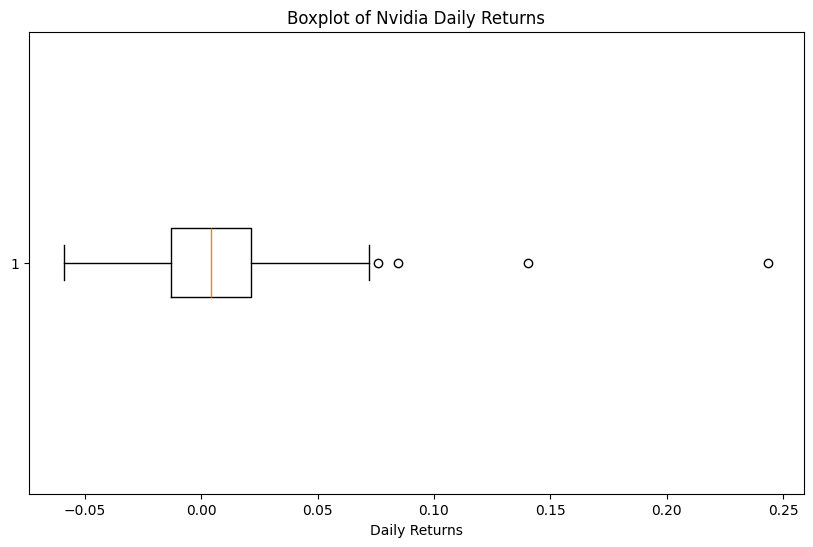

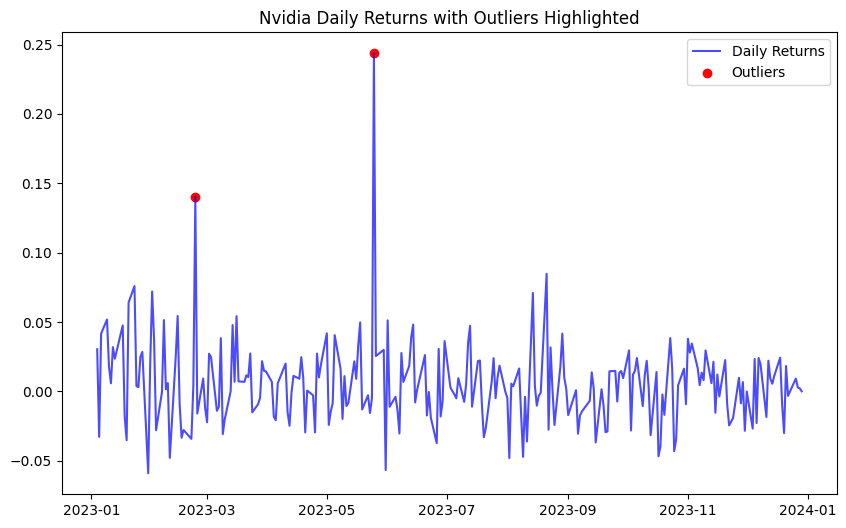

In [2]:
# Detect outliers using z-scores
nvidia['Z-Score'] = (nvidia['Daily Returns'] - nvidia['Daily Returns'].mean()) / nvidia['Daily Returns'].std()
nvidia['Outlier (Z-Score)'] = np.abs(nvidia['Z-Score']) > 3

# IQR method
Q1 = nvidia['Daily Returns'].quantile(0.25)
Q3 = nvidia['Daily Returns'].quantile(0.75)
IQR = Q3 - Q1
nvidia['Outlier (IQR)'] = (nvidia['Daily Returns'] < Q1 - 1.5 * IQR) | (nvidia['Daily Returns'] > Q3 + 1.5 * IQR)

# Count outliers
z_outliers = nvidia['Outlier (Z-Score)'].sum()
iqr_outliers = nvidia['Outlier (IQR)'].sum()

# Boxplot of daily returns
plt.figure(figsize=(10, 6))
plt.boxplot(nvidia['Daily Returns'], vert=False)
plt.title("Boxplot of Nvidia Daily Returns")
plt.xlabel("Daily Returns")
plt.show()

# Time-series plot with outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(nvidia.index, nvidia['Daily Returns'], label='Daily Returns', color='blue', alpha=0.7)
plt.scatter(nvidia.index[nvidia['Outlier (Z-Score)']],
            nvidia['Daily Returns'][nvidia['Outlier (Z-Score)']],
            color='red', label='Outliers', marker='o')
plt.title("Nvidia Daily Returns with Outliers Highlighted")
plt.legend()
plt.show()

## Section 3
This section applies linear regression models to both the original and winsorized Nvidia daily returns data. The goal is to evaluate the impact of outlier mitigation on model performance using metrics such as **R-squared** and **Root Mean Squared Error (RMSE)**.

**Steps:**
1. **Winsorization**: Mitigate outliers in the daily returns data by capping extreme values (5% in each tail).
2. **Data Preparation**: Add a time-based predictor column (`Day`) for the regression model.
3. **Model Fitting**: Fit separate linear regression models for:
   - Original daily returns
   - Winsorized daily returns
4. **Model Evaluation**: Compare the models using R-squared and RMSE.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from scipy.stats.mstats import winsorize

# Suppress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Linear regression on original and winsorized data
# Winsorize daily returns (capping at 5% both tails)
nvidia['Winsorized Returns'] = winsorize(nvidia['Daily Returns'], limits=[0.05, 0.05])

# Prepare data
nvidia['Day'] = np.arange(len(nvidia))  # Add a 'Day' column to use as a predictor
X_original = nvidia[['Day']]
y_original = nvidia['Daily Returns']
y_winsorized = nvidia['Winsorized Returns']

# Fit linear regression models
model_original = LinearRegression().fit(X_original, y_original)
model_winsorized = LinearRegression().fit(X_original, y_winsorized)

# Predict and evaluate models
y_pred_original = model_original.predict(X_original)
y_pred_winsorized = model_winsorized.predict(X_original)

# Calculate R-squared and RMSE
r2_original = r2_score(y_original, y_pred_original)
rmse_original = mean_squared_error(y_original, y_pred_original, squared=False)

r2_winsorized = r2_score(y_winsorized, y_pred_winsorized)
rmse_winsorized = mean_squared_error(y_winsorized, y_pred_winsorized, squared=False)

# Print metrics
print("Original Data Metrics:")
print(f"R-squared: {r2_original:.4f}, RMSE: {rmse_original:.4f}")
print("\nWinsorized Data Metrics:")
print(f"R-squared: {r2_winsorized:.4f}, RMSE: {rmse_winsorized:.4f}")

Original Data Metrics:
R-squared: 0.0163, RMSE: 0.0302

Winsorized Data Metrics:
R-squared: 0.0156, RMSE: 0.0230


## Section 4
This visualization compares the distributions of original and winsorized daily returns. Winsorization reduces the impact of extreme outliers by capping values at the tails of the distribution.

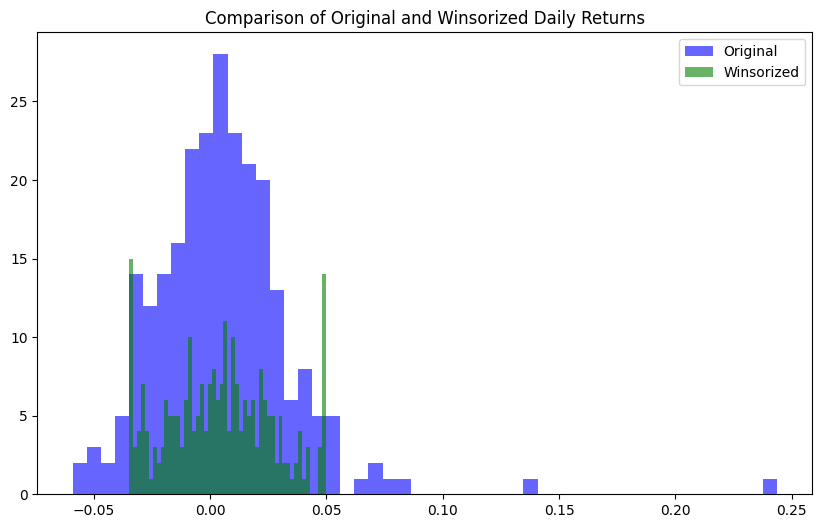

In [4]:
# Compare original and winsorized distributions
plt.figure(figsize=(10, 6))
plt.hist(nvidia['Daily Returns'], bins=50, alpha=0.6, label='Original', color='blue')
plt.hist(nvidia['Winsorized Returns'], bins=50, alpha=0.6, label='Winsorized', color='green')
plt.title("Comparison of Original and Winsorized Daily Returns")
plt.legend()
plt.show()

## Section 5
This section compares the summary statistics and volatility (standard deviation) of the original and winsorized daily returns. Winsorization typically reduces extreme variability, reflected in lower volatility values.

In [5]:
# Summary statistics before and after winsorization
print("Original Data Statistics:")
print(nvidia['Daily Returns'].describe())
print("\nWinsorized Data Statistics:")
print(nvidia['Winsorized Returns'].describe())

# Check the reduction in volatility (standard deviation)
original_volatility = nvidia['Daily Returns'].std()
winsorized_volatility = nvidia['Winsorized Returns'].std()

print(f"\nVolatility Reduction:\nOriginal: {original_volatility:.4f}, Winsorized: {winsorized_volatility:.4f}")

Original Data Statistics:
count    249.000000
mean       0.005442
std        0.030525
min       -0.059072
25%       -0.013069
50%        0.004315
75%        0.021308
max        0.243696
Name: Daily Returns, dtype: float64

Winsorized Data Statistics:
count    249.000000
mean       0.004234
std        0.023204
min       -0.034778
25%       -0.013069
50%        0.004315
75%        0.021308
max        0.049705
Name: Winsorized Returns, dtype: float64

Volatility Reduction:
Original: 0.0305, Winsorized: 0.0232
